# Continued from `tendency-sst-sss.ipynb` <a class="anchor" id="histogram"> </a> 

## Table Of Contents: <a class="anchor" id="top"> </a>
* [Create region mask object](#region-mask) 
* [Make histogram of each term](#histogram-terms)
* [Calculate Horizontal Turner Angle](#turner-angle)

In [49]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [50]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e2d7babfed3c4aad96467eeb944ef337/status,


In [26]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import json
import fsspec
import gcsfs
import xmitgcm
from xhistogram.xarray import histogram

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds_whole  = cat["CESM_POP_hires_control"].to_dask()

# Create region mask object <a class='anchor' id='region-mask'> </a>

In [31]:
grid_name = 'POP_gx1v7'

grid = pop_tools.get_grid(grid_name)
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [32]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask3d

<xarray.DataArray (region: 13, nlat: 384, nlon: 320)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
Dimensions without coordinates: nlat, nlon
Attributes:
    mask_name:  default

In [46]:
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Global', '90S-44S', 'Atl_44S-18S', 'Pac_44S-18S', 'Ind_44S-18S',
       'Atl_18S-18N', 'Pac_18S-18N', 'Ind_18S-30N', 'Atl_18N-49N',
       'Pac_18N-49N', 'Atl_49N-66N', 'Pac_49N-66N', 'Arc_66N-90N'],
      dtype='<U11')
Coordinates:
  * region   (region) <U11 'Global' '90S-44S' ... 'Pac_49N-66N' 'Arc_66N-90N'

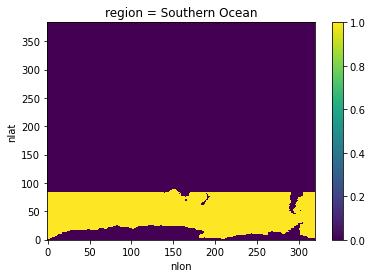

In [33]:
mask3d.sel(region='Southern Ocean').plot()

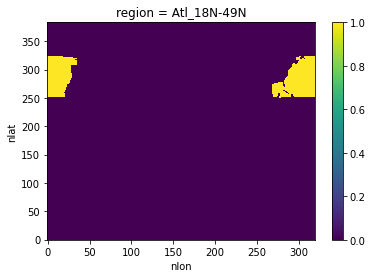

In [45]:
mask3d.sel(region='Atl_18N-49N').plot()

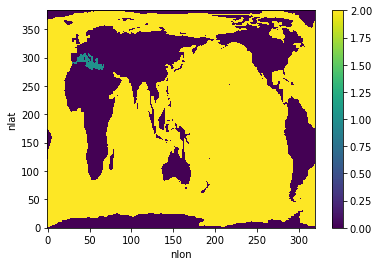

In [34]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='lat-range-basin')
mask3d.sum('region').plot();

In [35]:
hfacc = (mask3d.sum('region')/2).to_dataset(name='hfacc')

In [36]:
#mask is 6.25 x 11.25 times coarser than ds, need to interp?
hfacc

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    hfacc    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

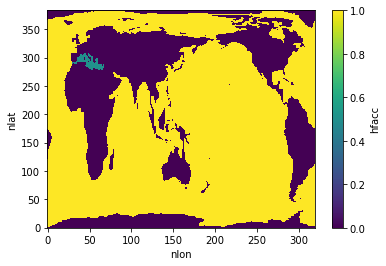

In [40]:
hfacc.hfacc.plot()

In [37]:
selection = dict(nlon=slice(300, 320), nlat=slice(0,50))

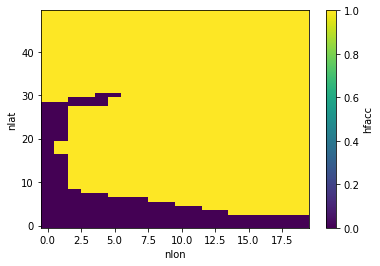

In [38]:
hfacc.hfacc.isel(**selection).plot()

# 4) Make histogram of each term <a class='anchor' id='histogram-terms'> </a>

- $\frac{\partial\rho}{\partial \theta} M(\theta)$
- $\frac{\partial\rho}{\partial s} M(S)$
- $M(\rho)$
- $C$
(use logarithmic scale on y-axis)

In [18]:
xr.testing.assert_allclose(ds_whole.nlat.reset_coords(drop=True), tendencies.nlat)

In [19]:
ds = tendencies.isel(time=0)

In [20]:
ds

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600)
Coordinates:
    time       object 0046-01-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SST_bih    (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cabbeling  (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    drhods     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    drhodt     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    rho_bih    (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>

### Define Volume

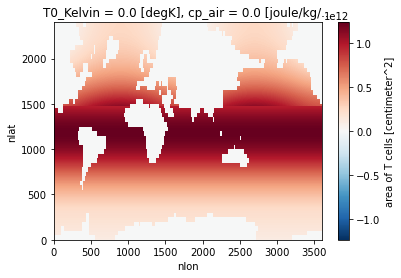

In [21]:
ds_whole.TAREA.plot()

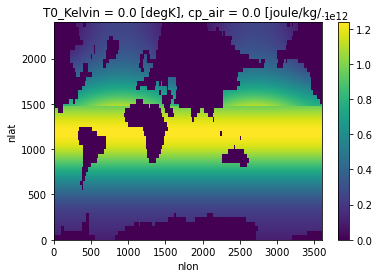

In [22]:
(ds_whole.DXT * ds_whole.DYT).plot()

In [23]:
diff = ds_whole.TAREA - (ds_whole.DXT * ds_whole.DYT)

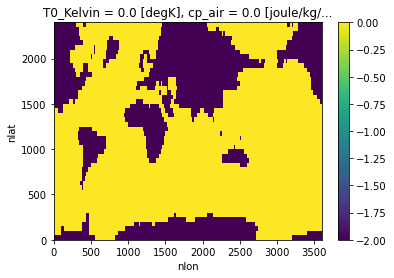

In [24]:
diff.plot()

(-0.001, 0.001)

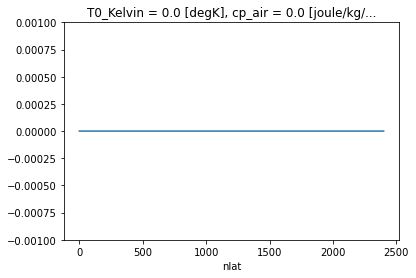

In [25]:
diff.all(dim='nlon').plot()
plt.ylim(-0.001, 0.001)

(-0.001, 0.001)

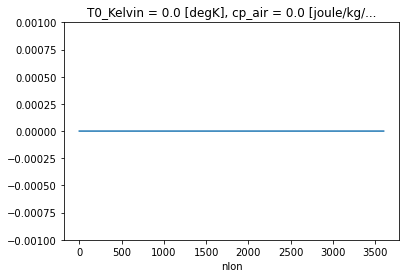

In [26]:
diff.all(dim='nlat').plot()
plt.ylim(-0.001, 0.001)

In [27]:
area = ds_whole.TAREA

## $\rho$ histogram

In [28]:
sss = ds_whole.SSS.isel(time=0)
sst = ds_whole.SST.isel(time=0)

In [29]:
rho = xr.apply_ufunc(jmd95numba.rho, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [30]:
rho

<xarray.DataArray (nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(2400, 3600), dtype=float32, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


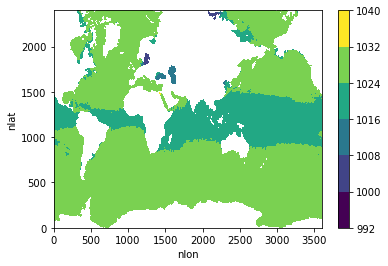

In [31]:
rho.plot.contourf()

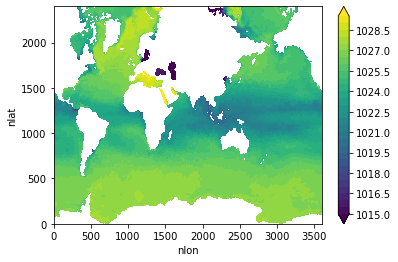

In [32]:
rho.plot.contourf(levels=np.arange(1015, 1030, 0.5))

In [33]:
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [34]:
rho_bins.size

1500

In [35]:
dens_dist = histogram(rho.rename('rho0'), bins=[rho_bins],
                         weights=area, dim=['nlon', 'nlat'])#.load()

In [36]:
sst_tend = ds.drhodt*ds.SST_bih
sss_tend = ds.drhods*ds.SSS_bih

In [37]:
tendency_terms = xr.merge([sst_tend.rename('sst_tend'), sss_tend.rename('sss_tend'),
                           ds.rho_bih.rename('dens_tend'), ds.cabbeling.rename('cabbeling_tend')])

In [38]:
all_tendencies = list(tendency_terms)

In [39]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlat', 'nlon'])
    return hist / delta_rho

In [40]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [41]:
histograms.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:               (rho0_bin: 1499)
Coordinates:
  * rho0_bin              (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst_tend        (rho0_bin) float32 -8.42e-06 4.646e-06 ... -3.848e-06
    OMEGA_sss_tend        (rho0_bin) float32 2.39e-05 2.489e-06 ... 7.119e-07
    OMEGA_dens_tend       (rho0_bin) float32 1.56e-05 7.149e-06 ... -3.108e-06
    OMEGA_cabbeling_tend  (rho0_bin) float32 -1.185e-07 -1.43e-08 ... -2.852e-08

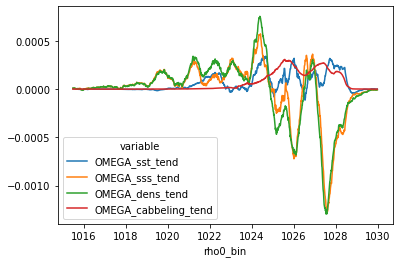

In [42]:
histograms.to_array().rolling(rho0_bin=50).mean().plot.line(hue='variable');

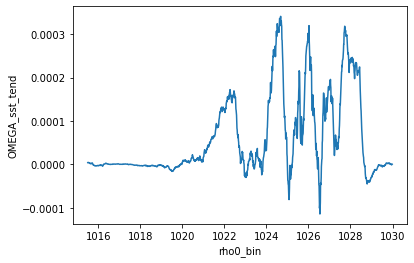

In [43]:
histograms.OMEGA_sst_tend.rolling(rho0_bin=50).mean().plot();

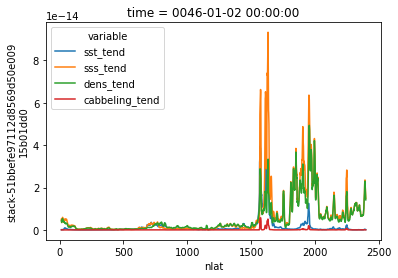

In [44]:
#Magnify the significant values by squaring to see if temp plays a bigger role than what we've seen in the above figs
(tendency_terms**2).mean('nlon').to_array().rolling(nlat=10).mean().plot.line(hue='variable');

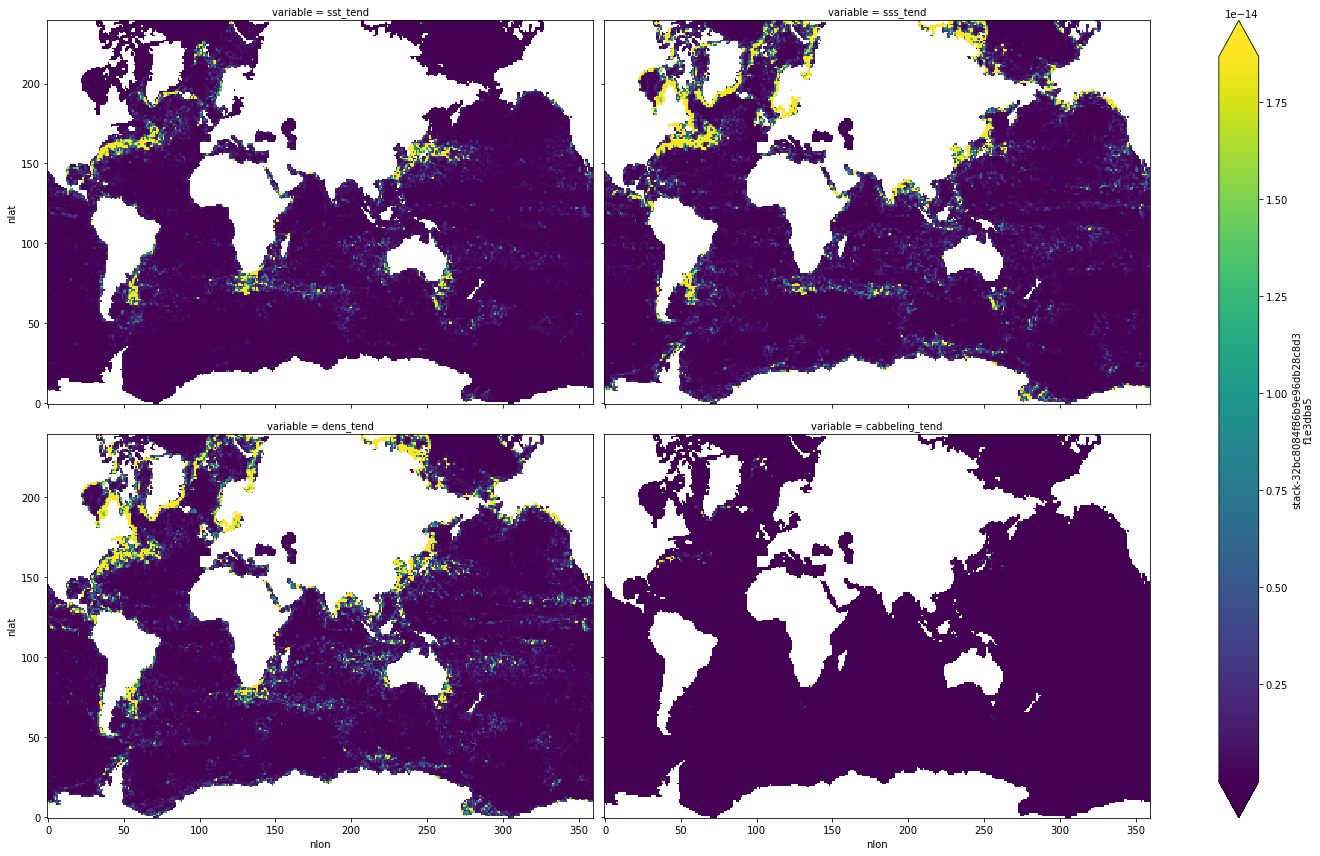

In [45]:
(tendency_terms**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', col_wrap=2, robust=True, figsize=(20, 12))

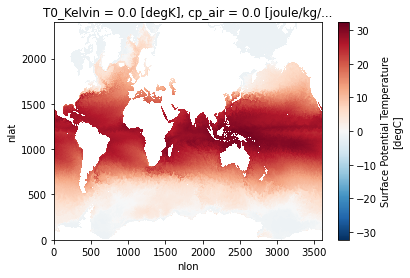

In [46]:
ds_whole.SST[0].plot()

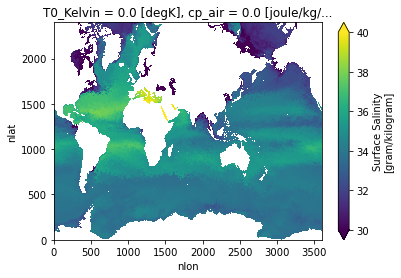

In [47]:
ds_whole.SSS[0].plot(vmin=30, vmax=40)

[Back to top](#top)

# 5) Calculate Horizontal Turner Angle <a class='anchor' id='turner-angle'></a>
$$Tu_h = atan2(\frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T + \beta \nabla S), \frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T - \beta \nabla S))$$

(Turner 1973, [Ruddick 1983](https://reader.elsevier.com/reader/sd/pii/0198014983900638?token=65952EBCA83FAAF5BF2480348931B38611B7AD90A9E27A17537E663CAF25691DF01538E4A5516463CD6E5ED33649AEEB&originRegion=us-east-1&originCreation=20220706161949), [Johnson et al., 2012](http://dx.doi.org/10.1029/2011JC007651))

- The atan() and atan2() functions calculate the arctangent of x and y/x, respectively. 
- The atan() function returns a value in the range -π/2 to π/2 radians. The atan2() function returns a value in the range -π to π radians. If both arguments of the atan2() function are zero, the function sets errno to EDOM, and returns a value of 0.

_Expanded form_

$$Tu_h = atan2(\frac{1}{|\nabla \rho|}\{\frac{\partial \rho}{\partial x}  [\alpha \frac{\partial T}{\partial x} + \beta \frac{\partial S}{\partial x}] + \frac{\partial \rho}{\partial y}  [\alpha \frac{\partial T}{\partial y} + \beta \frac{\partial S}{\partial y}]\}, \frac{1}{|\nabla \rho|}\{\frac{\partial \rho}{\partial x}  [\alpha \frac{\partial T}{\partial x} - \beta \frac{\partial S}{\partial x}] + \frac{\partial \rho}{\partial y}  [\alpha \frac{\partial T}{\partial y} - \beta \frac{\partial S}{\partial y}]\})$$

where,

$$\frac{1}{|\nabla \rho|} = \frac{1}{\sqrt{(\frac{\partial \rho}{\partial x})^2 + (\frac{\partial \rho}{\partial y}})^2}$$

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU']])

In [5]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds_drop)

In [6]:
def horizontal_turner_angle():
    """Compute horizontal turner angle given SST and SSS, 
        and user-defined basin selection"""
    
    def gradient(da):
        """Compute the gradients of T, S and rho"""
        
        da_diffx = grid.diff(da, 'X')
        da_diffy = grid.diff(da, 'Y', boundary='fill')
        da_diffx_interp = grid.interp(da_diffx, 'X')
        da_diffy_interp = grid.interp(da_diffy, 'Y', boundary='fill')
        dadx = da_diffx_interp/ds_ren.DXT
        dady = da_diffy_interp / ds_ren.DYT
        return dadx, dady
    
    #create grad-rho and |grad-rho| terms
    #rho = jmd95numba.rho(ds_ren.SSS, ds_ren.SST, 0).load()
    rho = xr.apply_ufunc(jmd95numba.rho, ds_ren.SSS, ds_ren.SST, 0,
                     output_dtypes=ds_ren.SST.dtype,
                     dask='parallelized', vectorize=True).reset_coords(drop=True)
    gradrho = gradient(rho)
    modgradrho = 1 / np.sqrt(gradrho[0]**2 + gradrho[-1]**2)
    
    #create gradT and gradS
    gradT = gradient(ds_ren.SST)
    gradS = gradient(ds_ren.SSS)
    
    #define alpha and beta
    runit2mass = 1.035e3 #rho_0
    drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SST.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    drhods = xr.apply_ufunc(jmd95numba.drhods, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SSS.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    alpha = - drhodt / runit2mass
    beta = drhods / runit2mass
    
    #define eq
    term1 = modgradrho*(gradrho[0]*(alpha*gradT[0] + beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] + beta*gradS[1]))
    term2 = modgradrho*(gradrho[0]*(alpha*gradT[0] - beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] - beta*gradS[1]))
    turner_angle = np.arctan2(term1, term2)
    
    return turner_angle

In [7]:
#weddell region
selection = dict(time=10, nlon_t=slice(470, 1000), nlat_t=slice(0,500))

#### Plot Turner angle

In [8]:
ta = horizontal_turner_angle()

In [9]:
ta

<xarray.DataArray (time: 14965, nlat_t: 2400, nlon_t: 3600)>
dask.array<arctan2, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: time

In [10]:
np.warnings.filterwarnings('ignore')

In [11]:
ta_deg1 = xr.ufuncs.degrees(ta)
ta_deg2 = xr.ufuncs.rad2deg(ta)

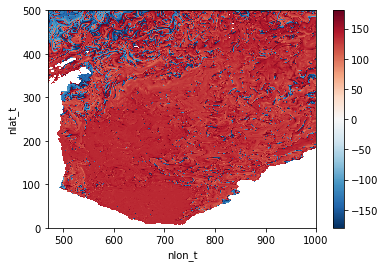

In [12]:
ta_deg1.isel(**selection).plot()

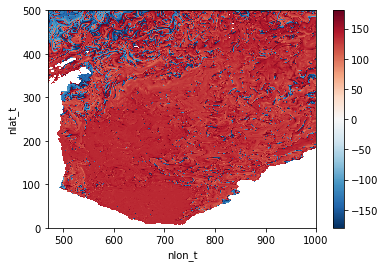

In [13]:
ta_deg2.isel(**selection).plot()

In [44]:
diff = ta_deg1 - ta_deg2

In [52]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e2d7babfed3c4aad96467eeb944ef337/status,


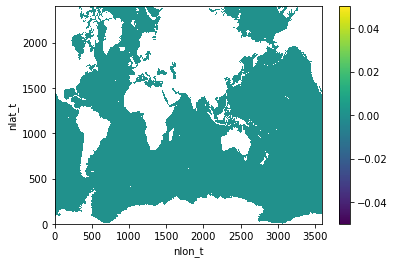

In [53]:
diff[10].plot()

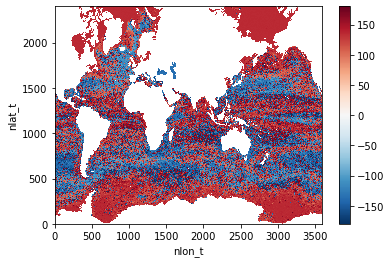

In [54]:
ta_deg1[10].plot()

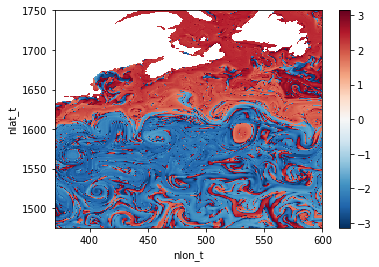

In [57]:
ta[10].isel(nlon_t=slice(370, 600), nlat_t=slice(1475,1750)).plot()

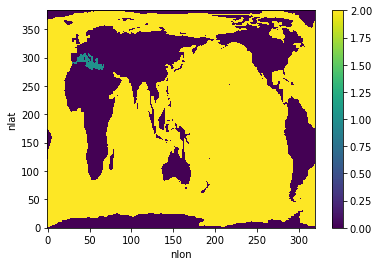

In [10]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='lat-range-basin')
mask3d.sum('region').plot();

In [93]:
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

In [94]:
mask3d.sel(region='Southern Ocean')

<xarray.DataArray (nlat: 384, nlon: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    region   <U21 'Southern Ocean'
Dimensions without coordinates: nlat, nlon
Attributes:
    mask_name:  default

In [105]:
mask3d.sel(region='Southern Ocean')

<xarray.DataArray (nlat: 384, nlon: 320)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    region   <U21 'Southern Ocean'
Dimensions without coordinates: nlat, nlon
Attributes:
    mask_name:  default

In [98]:
ds_whole.dims

Frozen({'nlat': 2400, 'nlon': 3600, 'time': 14965, 'z_t': 62, 'z_w': 62, 'z_t_150m': 15, 'z_w_bot': 62, 'z_w_top': 62})

In [103]:
tend_interp = tendencies.interp(nlon=mask3d.nlon, nlat=mask3d.nlat)
tend_interp

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 384, nlon: 320)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
    nlat       (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383

In [104]:
tend_interp.where(mask3d.sel('Southern Ocean'))

ValueError: the first argument to .sel must be a dictionary

[Back to top](#top)